# Hands-on damage detection for rolling bearings with Keras and Tensorflow

## 1. Introduction 
This notebook shows a CNN in Keras for damage detection in rolling bearings and it is the hands-on counterpart of the blog post [Convolutional Neural Network for damage detection](blog_link). The original dataset is from the [Case Western Reserve University](http://csegroups.case.edu/bearingdatacenter/home). We provide a mirror on AWS S3 of this dataset (just a copy of the original files) as the orignal source is not friendly to mass downloading. If you are using the dataset, please refer the original source and not our repository.

### 1.1 Installing Keras and other prerequisite
This project is based on Keras with TensorFlow backend for the implementation of the CCN and on many libraries for signal processing. To install all the prerequisite, we use `virtualenv` and `pip`. Go to terminal in the project folder and execute the following commands:
```bash
python3.7 -m venv ./venv
source ./venv/bin/activate
pip3 install ipykernel
ipython kernel install --user --name=deep-predict
jupyter notebook```

Now, in your Jupyter notebook, just go to the menu `Kernel` and select `Change Kernel`, you'll find the `deep_predict`. As next step, we install all the project's requirements:

In [ ]:
!pip3 install --upgrade -q -r './requirements.txt'

So, now we are good to go! Let's start downloding the data.

## 2. Download the raw data

We write an helper function to download the datasets and to create a dataset folder. The function `download_rawdata_files` accepts a parameter which can have the values "S3", or "original". The "S3" value is the default and recommended as we said before. The data set is a bundle of the matlab file whose name is just a number (such as "118.mat"), not very expressive. As we would like to label the file with more expressive name, which explicitly say the kind of experiment that the file contains, we need a mapping. Our naming ha the following format: `{state}{damage size}@{position of the sensor}_{load}.mat` where:
* `state` can be 
     - `N` for normal state, not damaged
     - `B` for ball damaged
     - `IR` for inner raceway damage
     - `OR` for outer raceway damage
* `damage size` is the size of the tested damage:
    - `007` for 0.07 inch damage
    - `014` for 0.14 inch damage 
    - `021` for 0.21 inch damage
    - `028` for 0.28 inch damage  
* `position of the sensor` can be:
    - `3`, `6`, `12` for outer raceway faults located at 3 o’clock (directly in the load zone), at 6 o’clock (orthogonal to the load zone), and at 12 o’clock, respectively
* `load`can be:
    - `0`, `1`, `2`, `3` for different motor load conditions, in powerhorse unit

So, for example the file `IR021_2.mat` contains the data of the experiment conducted with `inner raceway` of damage size `0.21 inches` at `2 HP`. Better than `221.mat` isn'it? Then let's create a list that contains this mapping:

In [1]:
mapping_code_to_mat = [('B007_0', '118'), ('B007_1', '119'), ('B007_2', '120'), ('B007_3', '121'), ('B014_0', '185'), ('B014_1', '186'), ('B014_2', '187'), ('B014_3', '188'), ('B021_0', '222'), ('B021_1', '223'), ('B021_2', '224'), ('B021_3', '225'), ('B028_0', '3005'), ('B028_1', '3006'), ('B028_2', '3007'), ('B028_3', '3008'), ('IR007_0', '105'), ('IR007_1', '106'), ('IR007_2', '107'), ('IR007_3', '108'), ('IR014_0', '169'), ('IR014_1', '170'), ('IR014_2', '171'), ('IR014_3', '172'), ('IR021_0', '209'), ('IR021_1', '210'), ('IR021_2', '211'), ('IR021_3', '212'), ('IR028_0', '3001'), ('IR028_1', '3002'), ('IR028_2', '3003'), ('IR028_3', '3004'), ('Normal_0', '97'), ('Normal_1', '98'), ('Normal_2', '99'), ('Normal_3', '100'), ('OR007@12_156', '156'), ('OR007@12_158', '158'), ('OR007@12_159', '159'), ('OR007@12_160', '160'), ('OR007@3_144', '144'), ('OR007@3_145', '145'), ('OR007@3_146', '146'), ('OR007@3_147', '147'), ('OR007@6_130', '130'), ('OR007@6_131', '131'), ('OR007@6_132', '132'), ('OR007@6_133', '133'), ('OR014@6_197', '197'), ('OR014@6_198', '198'), ('OR014@6_199', '199'), ('OR014@6_200', '200'), ('OR021@12_258', '258'), ('OR021@12_259', '259'), ('OR021@12_260', '260'), ('OR021@12_261', '261'), ('OR021@3_246', '246'), ('OR021@3_247', '247'), ('OR021@3_248', '248'), ('OR021@3_249', '249'), ('OR021@6_234', '234'), ('OR021@6_235', '235'), ('OR021@6_236', '236'), ('OR021@6_237', '237')]

In [2]:
from os import path
import errno
import os
import urllib.request
                          
# set the url for downloading the data from codecentric S3 bucket (recommended)
url_s3 = "https://s3.eu-central-1.amazonaws.com/predictron-datasets/"
                          
# set the original url for downloading the data from csegroups (original source)
url_original = "http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/"               

def try_make_directories():     
    data_directories = ["dataset", "npy_dataset"]
    for directory in data_directories:
        try:
            os.makedirs(f'./{directory}')
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

def download_rawdata_files(source_of_files="S3"):


    try_make_directories()

    for map_code, map_mat in mapping_code_to_mat:
        row_code = str(map_code).strip()
        row_mat = str(map_mat).strip()
        local_filename = f'./dataset/{row_code}.mat'

        if source_of_files == "S3":
            if row_code.endswith(row_mat):
                remote_filename = f'{row_code}.mat'
            else:
                remote_filename = f'{row_code}_{row_mat}.mat'
            url = url_s3
        elif source_of_files == 'original':
            remote_filename = f'{row_mat}.mat'
            url = url_original
        else:
            print("No valid source of files specified. Exiting.")
            return

        full_url = f'{url}{remote_filename}'
        print(full_url)

        if os.path.isfile(local_filename):
            print(f'File {local_filename} already exists. Skipping.')
            continue
        print('Downloading...')
        urllib.request.urlretrieve(full_url, local_filename)
        print(f'Downloaded: {local_filename}')
    return

In [3]:
%%capture 
download_rawdata_files()

If it all looks good, then now we have all the raw data we need to continue to the next Notebook.

### 2.1 How does the matlab file looks like?

Let's have a look at one matlab file, importing it with `scipy`. 

In [4]:
import scipy.io as sio
sio.loadmat(f"./dataset/Normal_0.mat")

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Mon Jan 31 15:28:20 2000',
 '__version__': '1.0',
 '__globals__': [],
 'X097_DE_time': array([[ 0.05319692],
        [ 0.08866154],
        [ 0.09971815],
        ...,
        [-0.03463015],
        [ 0.01668923],
        [ 0.04693846]]),
 'X097_FE_time': array([[0.14566727],
        [0.09779636],
        [0.05485636],
        ...,
        [0.14053091],
        [0.09553636],
        [0.09019455]]),
 'X097RPM': array([[1796]], dtype=uint16)}

It is python dictionary with keys with the format `X{file name}_{code}_time`, where
* `file name` is the original file name in the dataset, like `097.mat`
* `code` is the sensor position and can be:
    - `DE` if the data comes from the sensor at the drive end of the motor
    - `FE` if the data comes from the sensor at the fan end of the engine
    - `B`  if the data comes from the sensor attached at the base of the test setup

We will use only the data collected at the drive end, labelled with the code `DE`. So, we write a function that pick up the time signal from a file, for given code, making a regex on the dictionary keys, looking for the the code and not caring of the `X{filename}` prefix and `time` suffix. We use a function for this task and we also convert the unit to SI units.

In [5]:
def time_signal(file, code):
    """
    load the time series in the file and convert units in SI
    file= 'filename' from the ./dataset/ folder
    code= ' DE' or 'FE', other code will give error
    """
    import re
    try:
        import scipy.io as sio
        data = sio.loadmat(f"./dataset/{file}.mat")
        for key in data:
            if re.findall(rf"({code})", key):
                dict_code = key
        unit_conv = 0.0254
        x = data[dict_code] * unit_conv
        return x
    except:
        print('File does not exist or code wrong. Code must be either "DE or "FE" ')

Now we can plot some signals with code= `DE`. The data is sampled at 12kHz, that is 12000 data points per second. Let's plot 1/10 of seconds: 

/Users/giulio/Documents/projects/codecentric/pred_maintenance/dev/deep-predict/venv/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


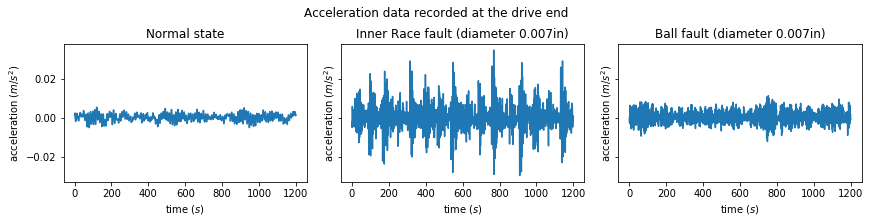

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

normal_sig = time_signal(file='Normal_0', code='DE')
ir_sig = time_signal(file='IR007_0', code='DE') 
b_sig = time_signal(file='B007_0', code='DE') 

range_of_samples = range(0,1200)

# plotting

fig, (plt1, plt2, plt3) = plt.subplots(1, 3, sharey = True, figsize=(12,3), constrained_layout=True)
plt1.set_xlabel("time $(s)$")
plt1.set_ylabel("acceleration $(m/s^2)$")
plt1.set_title('Normal state')
plt1.plot(normal_sig[range_of_samples])
plt2.set_xlabel("time $(s)$")
plt2.set_ylabel("acceleration $(m/s^2)$")
plt2.set_title('Inner Race fault (diameter 0.007in)')
plt2.plot(ir_sig[range_of_samples])
plt3.set_xlabel("time $(s)$")
plt3.set_ylabel("acceleration $(m/s^2)$")
plt3.set_title('Ball fault (diameter 0.007in)')
plt3.plot(b_sig[range_of_samples])
fig.suptitle('Acceleration data recorded at the drive end')
fig.show()

## 3. Architecture of the CNN

As the picture in our [blogpost](blog_link) shows , we can distinguish four main conceptual phases.

1. Data chunking
2. Feature engineering
3. Data shuffling
4. Convolutional Neural Network

### 3.1. Data chunking

We'll divide the signal in chunks of size `chunk_size`, and take a subset `number_of_chunks` from all the available for training and testing the CNN. A chunk is simply a sequential subset of the time series data with a fixed length - the `chunk_size`. Every chunk is distinct - there are no overlapping samples in different chunks. 
This method is said _tumbling time windowing_, for more info you can see this [blog post](https://blog.codecentric.de/en/2018/10/window-functions-in-stream-analytics/). 
Each time series is an array, and they have slight difference in length. This means that if we fix a chunk size to divide the file, we need a function to split the data exaclty in `number_of_chunks` of `chunk_size` and get rid of the remaining part. We can write a function for that, `split_exact`, which takes the array to be splitted, the number of chunks and the array axis to be splitted. 


In [7]:
def split_exact(x, n_chunks=2, axis=1):
    import numpy as np
    l = np.shape(x)[axis]
    x_split = x
    if l > n_chunks > 1:
        n = n_chunks
        if axis == 0:
            x_split = np.split(x[:-(l % n)], n, axis=axis)
        elif axis == 1:
            x_split = np.split(x[:, :-(l % n)], n, axis=axis)
    return x_split

Next, we perform some operation on the data. First of all we will consider only:

* the normal data labelled as `N`
* the inner raceway data labelled as `IR`
* the ball damage data labelled as `B`

that is, we skip the outer raceway data in this implementation.

We join the data for every load, from `0...3` HP, normalizing it with respect to the standard deviation. This is because we want our CNN to classify the status independently from the load. To this aim, we write the function `load_raw_matlab_data` which returns three multidimensional arrays for `N, IR, B` data with dimension the maximum `number_of_chuncks` obtainable from the data, by `chunk_size`. 

In [8]:
import numpy as np

def load_raw_matlab_data(chunk_size=128):
    """
    Load the mat files and splits it in chunks of size chunk_size
    returns:
        array_normal, array_ir, array_b
    """
    y_n: ndarray = np.array([])
    # normal signal
    for i in (0, 1, 2, 3):
        x = time_signal(file='Normal_' + str(i), code='DE').flatten()
        x = x / np.std(x)
        y_n = np.append(y_n, x)
    n_splits = len(y_n) // chunk_size
    y_n = split_exact(y_n, n_chunks=n_splits, axis=0)

    y_ir: ndarray = np.array([])
    for i in ('007', '014', '021', '028'):
        for j in (0, 1, 2, 3):
            x = time_signal(file='IR' + i + '_' + str(j), code='DE').flatten()
            x = x / np.std(x)
            y_ir = np.append(y_ir, x)
    n_splits = len(y_ir) // chunk_size
    y_ir = split_exact(y_ir, n_chunks=n_splits, axis=0)

    y_b: ndarray = np.array([])
    for i in ('007', '014', '021', '028'):
        for j in (0, 1, 2, 3):
            x = time_signal(file='B' + i + '_' + str(j), code='DE').flatten()
            x = x / np.std(x)
            y_b = np.append(y_b, x)
    n_splits = len(y_b) // chunk_size
    y_b = split_exact(y_b, n_chunks=n_splits, axis=0)

    return y_n, y_ir, y_b

So let's initialize the data using the latter function.

In [9]:
chunk_size = 1200
number_of_chunks=1400

normal_data_clean, ir_data_clean, b_data_clean = load_raw_matlab_data(chunk_size=chunk_size)

### 3.2. Feature engineering

Each chunk of data is preprocessed. We extract a time/fequency image of each chunk with three different preprocessing techniques. For all the images we use a min max normalization, to have color mapping only in the range `[0,1]`.

In [10]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

### 3.2.1. Short Time Fourier Transform
The function `generate_spectrogram_image(data_y_vector, image_shape)` takes a time series as input and the resolution of the image that it will generate and returns the Short time Fourier normalized in the range `[0,1]`.

In [11]:
from scipy import signal
from skimage.transform import resize

def generate_spectrogram_image(data_y_vector, image_shape):
    """
    Calculate the spectrogram of an array data_y_vector and resize it in 
    the image_shape resolution
    """
    fs = 12000.
    data_y_vector_len = np.shape(data_y_vector)[0]

    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs)

    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)

    return sxx

Let's have a look at the Short Time Fourier Transform of one chunck of the data `N`, `IR` and `B`:

/Users/giulio/Documents/projects/codecentric/pred_maintenance/dev/deep-predict/venv/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


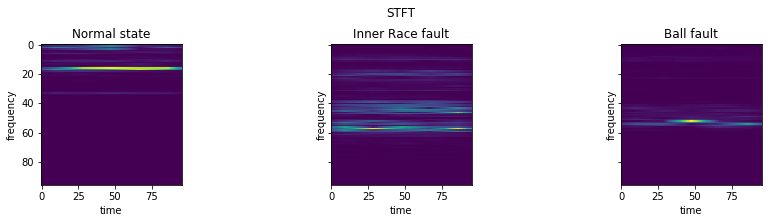

In [12]:
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, sharey = True, figsize=(12,3), constrained_layout=True)
plt1.set_xlabel("time")
plt1.set_ylabel("frequency")
plt1.set_title('Normal state')
plt1.imshow(generate_spectrogram_image(normal_data_clean[42], (96,96)))
plt2.set_xlabel("time")
plt2.set_ylabel("frequency")
plt2.set_title('Inner Race fault')
plt2.imshow(generate_spectrogram_image(ir_data_clean[42], (96,96)))
plt3.set_xlabel("time")
plt3.set_ylabel("frequency")
plt3.set_title('Ball fault')
plt3.imshow(generate_spectrogram_image(b_data_clean[42], (96,96)))
fig.suptitle('STFT')
fig.show()

In the `./colab/` folder of this repo, the other transforms are implemented, please refer to that folder!'

### 3.3. Data shuffling

Now it is time to create the whole bunch of images we are going to use to train the CNN. We are going to need some functions to help us in creating the folders in which the images will be stored, and to label correctly the file we generate, depending on the parameters we choose, such as `number_of_chunks`, `chunk_size`, `image_shape` in dpi. We implement a random shuffling between the chunks at this stage, to avoid that the CNN is trained on images that are representative of adjacent time windows.

In [13]:
from tqdm import tqdm
from enum import Enum

def create_image_by_label_database(
        number_of_chunks,
        chunk_size,
        image_types,
        image_shape,
        noise_scale = 0.0,
        shuffle_chunks_across_time=True,
        overwrite_existing_file=False):

    try_make_directories()

    filename_for_images_by_labels = npy_dataset_filename(
        number_of_chunks,
        chunk_size,
        image_types,
        image_shape,
        noise_scale,
        shuffle_chunks_across_time
    )

    if overwrite_existing_file is False:
        import os
        if os.path.isfile(filename_for_images_by_labels):
            print(
                "File already exists. Use 'overwrite_existing_file' if you wish to regenerate and overwrite it. Bye.")
            return

    normal_data_clean, ir_data_clean, b_data_clean = load_raw_matlab_data(chunk_size=chunk_size)

    len_n = np.shape(normal_data_clean)[0]
    len_ir = np.shape(ir_data_clean)[0]
    len_b = np.shape(b_data_clean)[0]
    len_data = min(len_n, len_ir, len_b, number_of_chunks)

    # add some noise maybe
    normal_data = [x + y for x, y in
                   zip(normal_data_clean, [np.random.normal(0, noise_scale, chunk_size) for i in range(len_n)])]
    ir_data = [x + y for x, y in
               zip(ir_data_clean, [np.random.normal(0, noise_scale, chunk_size) for i in range(len_ir)])]
    b_data = [x + y for x, y in zip(b_data_clean, [np.random.normal(0, noise_scale, chunk_size) for i in range(len_b)])]

    if shuffle_chunks_across_time:
        # so the first N chunks will be taken at random time from the whole time window
        np.random.shuffle(normal_data)
        np.random.shuffle(ir_data)
        np.random.shuffle(b_data)

    images_by_labels = {'n': [], 'ir': [], 'b': []}

    for i in tqdm(np.arange(len_data)):
        n_images = generate_rgba_images_from_data(normal_data[i], image_shape, image_types)
        ir_images = generate_rgba_images_from_data(ir_data[i], image_shape, image_types)
        b_images = generate_rgba_images_from_data(b_data[i], image_shape, image_types)

        images_by_labels['n'].extend(n_images)
        images_by_labels['ir'].extend(ir_images)
        images_by_labels['b'].extend(b_images)

    print(f'Saving {filename_for_images_by_labels}')
    np.save(f'{filename_for_images_by_labels}', images_by_labels)
    
def npy_dataset_filename(
        number_of_chunks,
        chunk_size,
        image_types,
        image_shape,
        noise_scale,
        chunks_are_shuffled_across_time):
    filename_suffix = \
        f'__chunks{number_of_chunks}' \
        f'_size{chunk_size}' \
        f'_types{"-".join([str(t)[10:12] for t in image_types])}' + \
        (f'_noise{noise_scale}' if noise_scale > 0 else '') + \
        (f'_timeshuffled' if chunks_are_shuffled_across_time else '') + \
        f'_shape{image_shape[0]}-{image_shape[1]}'
    filename = f'./npy_dataset/images_by_labels_for_cnn{filename_suffix}.npy'
    return filename
    
def generate_rgba_images_from_data(
        vector_y_data,
        image_shape,
        image_types):
    images = []
    if ImageType.SCALOGRAM in image_types:
        images.append(generate_scalogram_image(vector_y_data, image_shape))
    if ImageType.SPECTROGRAM in image_types:
        images.append(generate_spectrogram_image(vector_y_data, image_shape))
    if ImageType.QTRANSFORM in image_types:
        images.append(generate_qtransform_image(vector_y_data, image_shape))

    images_rgba = ary_to_rgba(images)

    return images_rgba

def ary_to_rgba(ary, nchannels=4):
    from matplotlib import cm

    ary_dim = (np.shape(ary))

    im = np.empty(shape=(ary_dim[0], ary_dim[1], ary_dim[2], nchannels)).astype('uint8')
    for i in np.arange(0, len(ary)):
        im[i, :] = cm.ScalarMappable(cmap='viridis').to_rgba(10 * np.log(ary[i] + 0.001), bytes=True, norm=True)
    return im

class ImageType(Enum):
    SCALOGRAM = 1
    SPECTROGRAM = 2
    QTRANSFORM = 3

Let's define the parameters of the preprocessing:

In [14]:
chunk_size = 1200
number_of_chunks=1400
image_types=[ImageType.SPECTROGRAM]
image_shape = (96, 96)
shuffle_chunks_across_time=True

In [15]:
create_image_by_label_database(
    number_of_chunks=number_of_chunks, 
    chunk_size=chunk_size, 
    image_types=image_types, 
    image_shape=image_shape, 
    shuffle_chunks_across_time=shuffle_chunks_across_time,
    overwrite_existing_file=True)

100%|██████████| 1400/1400 [00:06<00:00, 205.07it/s]


Saving ./npy_dataset/images_by_labels_for_cnn__chunks1400_size1200_typesSP_timeshuffled_shape96-96.npy


### 3.4. Convolutional Neural Network

The CNN architecture we use in this notebook is taken from the paper [Deep Learning Enabled Fault Diagnosis Using Time-Frequency Image Analysis of Rolling Element Bearings](https://www.hindawi.com/journals/sv/2017/5067651/). It is from the paper of Guo et al. and it is used in the paper as comparison. We decided to use this architecture due to the low number of parameters and the very good results in terms of precision, even under noisy conditions.

### 3.4.1 Train-test data prep

Let's define a function that loads the images we generated. We repeat here the parameters for the file generation, so that you can also restart the notebook directly from here.

In [16]:
chunk_size = 1200
number_of_chunks=1400
image_types=[ImageType.SPECTROGRAM]
image_shape = (96, 96)
shuffle_chunks_across_time=True

In [17]:
def load_images_by_labels_by_params(
        number_of_chunks,
        chunk_size,
        image_types ,
        image_shape,
        noise_scale = 0.0,
        chunks_are_shuffled_across_time=True):
    filename = npy_dataset_filename(
        number_of_chunks,
        chunk_size,
        image_types,
        image_shape,
        noise_scale,
        chunks_are_shuffled_across_time)

    loaded = np.load(filename)
    print(f"Successfully loaded file {filename}")
    return loaded.item()  # item() gets the actual dictionary from the loaded object

With the aid of the previous function we load the images.

In [18]:
images_by_labels_for_cnn = load_images_by_labels_by_params(
    chunk_size=chunk_size, 
    number_of_chunks=number_of_chunks,     
    image_types=image_types, 
    image_shape=image_shape,
    chunks_are_shuffled_across_time=shuffle_chunks_across_time)

Successfully loaded file ./npy_dataset/images_by_labels_for_cnn__chunks1400_size1200_typesSP_timeshuffled_shape96-96.npy


Now, to transform the data to a form suitable for feeding to the CNN, we:
- separate the images and their labels into two arrays, correlated by their indexes
- have the labels one-hot encoded (i.e. label "N" becomes (0,0,1))

Additionally, to get a good distribution of data types accross the training and test data, we interleave the three types of data, that is we get a single array, containing all the images, where sequential images are always having a different data type (N, IR, or B) in the form [ ..., "N", "IR", "B", "N", "IR", "B",  ...]. This is implemented in the function `separate_images_from_labels`:

In [19]:
def separate_images_from_labels(images_by_labels, interleave: bool):
    all_labels = list(images_by_labels.keys())
    NB_CLASSES = len(all_labels)
    all_labels_onehot = np.identity(NB_CLASSES).astype('uint8')
    label_to_onehot_mapper = {all_labels[i]: all_labels_onehot[i] for i in np.arange(NB_CLASSES)}

    all_images_for_cnn = []
    all_labels_for_cnn_onehot = []

    for key in all_labels:
        images = images_by_labels[key]
        labels_onehot = np.full(shape=(len(images), NB_CLASSES), fill_value=label_to_onehot_mapper[key])

        all_images_for_cnn.append(images)
        all_labels_for_cnn_onehot.append(labels_onehot)

    if interleave:
        all_images_for_cnn = lists_interleave(all_images_for_cnn)
        all_labels_for_cnn_onehot = lists_interleave(all_labels_for_cnn_onehot)
    else:  # flatten the lists
        all_images_for_cnn = [image for sublist in all_images_for_cnn for image in sublist]
        all_labels_for_cnn_onehot = [label for sublist in all_labels_for_cnn_onehot for label in sublist]

    return np.array(all_images_for_cnn), np.array(all_labels_for_cnn_onehot)
                               
def lists_interleave(lists):
    return [val for tup in zip(*lists) for val in tup]

The last step before training is to separate the images into training set and testing set

In [20]:
from sklearn.model_selection import train_test_split

images_for_cnn, labels_for_cnn_onehot = separate_images_from_labels(images_by_labels_for_cnn, interleave=True)

images_train, images_test, labels_train_onehot, labels_test_onehot = \
    train_test_split(
        images_for_cnn, 
        labels_for_cnn_onehot, 
        test_size=0.33, 
        random_state=42)

### 3.4.2 CNN model with Keras

The problem we want to solve is a supervised classification problem, with three classes. We use Convolutional Neural Networks implemented as Sequential Keras model. Our installation of Keras exploits TensorFlow as backend for the tensor arithmetics. 

The images that we have previously generated form a tuple `(number of images, x dpi, y dpi, number of channels)`. We use the **categorical cross-entropy** loss function and **ADAM** optimizer and Leaky RELU activation function. The learning rate has been found by using cyclical learning rate algorithm of Smith. An implementation of the algorithm by Keras callback is in the `./colab` folder.

In [21]:
from keras import optimizers

## input data parameters
IMAGES_SHAPE = (96, 96, 4)
PADDING = 'same'
KERNEL_SIZE = (5, 5)
KERNEL_INITIALIZER = 'glorot_normal'
# parameters for deep layers
NUMBER_OF_CLASSES = 3  # N, IR and B
DROPOUT = 0.5
LEAK_ALPHA = 0.1
MAX_POOLING_POOL_SIZE = (2, 2)
ACTIVATION_LAYER_FUNCTION = 'softmax'
# loss and optimizer
LOSS_FUNCTION = 'categorical_crossentropy'
LEARNING_RATE = 0.001
OPTIMIZER = optimizers.Adam(LEARNING_RATE, epsilon=10e-6)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [22]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import LeakyReLU
from keras import metrics


# CNN architecture from Guo et al.
model = Sequential()
model.add(Conv2D(5, KERNEL_SIZE,                  
                 input_shape=IMAGES_SHAPE,
                 data_format='channels_last',
                 kernel_initializer=KERNEL_INITIALIZER,                 
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Conv2D(10, KERNEL_SIZE, 
                 kernel_initializer=KERNEL_INITIALIZER,
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(MaxPooling2D(pool_size=MAX_POOLING_POOL_SIZE))
model.add(Conv2D(10, KERNEL_SIZE, 
                 kernel_initializer=KERNEL_INITIALIZER,
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(MaxPooling2D(pool_size=MAX_POOLING_POOL_SIZE))
model.add(Flatten())
model.add(Dense(10))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Dense(5))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Dropout(DROPOUT))
model.add(Dense(NUMBER_OF_CLASSES))
model.add(Activation(ACTIVATION_LAYER_FUNCTION))
  
model.compile(loss=LOSS_FUNCTION, 
              optimizer=OPTIMIZER,
              metrics=[metrics.categorical_accuracy])  
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 5)         505       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 5)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 10)        1260      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 10)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 10)        2510      
___________________________

### 3.4.3 Training the CNN

We train the CNN with a validation split of 1/4 of the image batch size and over 30 epochs. The CNN will be then tested on the hold-out data. 

In [23]:
BATCH_SIZE = 64
NUMBER_OF_EPOCHS = 5
VALIDATION_SPLIT = 0.25

history = model.fit(
    images_train, labels_train_onehot,
    batch_size=BATCH_SIZE,
    epochs=NUMBER_OF_EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 2110 samples, validate on 704 samples
Epoch 1/5
2110/2110 [==============================] - 21s 10ms/step - loss: 1.1988 - categorical_accuracy: 0.6427 - val_loss: 0.3023 - val_categorical_accuracy: 0.9247
Epoch 2/5
2110/2110 [==============================] - 21s 10ms/step - loss: 0.4460 - categorical_accuracy: 0.7848 - val_loss: 0.1679 - val_categorical_accuracy: 0.9631
Epoch 3/5
2110/2110 [==============================] - 21s 10ms/step - loss: 0.3471 - categorical_accuracy: 0.8047 - val_loss: 0.0814 - val_categorical_accuracy: 0.9986
Epoch 4/5
2110/2110 [==============================] - 21s 10ms/step - loss: 0.2793 - categorical_accuracy: 0.8384 - val_loss: 0.0457 - val_categorical_accuracy: 1.0000
Epoch 5/5
2110/2110 [==============================] - 21s 10ms/step - loss: 0.2591 - categorical_accuracy: 0.8389 - val_loss: 0.0178 - val_categorical_accuracy: 1.0000


### 3.4.4 Test the CNN
Once the model has been fitted, we assess its precision through a classical one vs many confusion matrix.

In [24]:
labels_predicted = history.model.predict_classes(images_test, verbose=1)

1386/1386 [==============================] - 6s 4ms/step


In [25]:
# for the confusion matrix we need a factorized labels 
# [1,0,0] -> 0 ("N")
# [0,1,0] -> 1 ("IR")
# [0,0,1] -> 2 ("B")
labels_test_factorized = [(1*label[0]+2*label[1]+3*label[2])-1 for label in labels_test_onehot]

from sklearn.metrics import classification_report
print(classification_report(labels_test_factorized, labels_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       497
           1       1.00      1.00      1.00       448
           2       1.00      1.00      1.00       441

   micro avg       1.00      1.00      1.00      1386
   macro avg       1.00      1.00      1.00      1386
weighted avg       1.00      1.00      1.00      1386



## 4. ROC analysis
The ROC curves for each class give a complete picture of the classification performance of the CNN. It is convenient to write a function that takes this task.

In [26]:
def ROC(model, X_test, y_test, n_class):
    import seaborn as sns
    from sklearn.metrics import roc_curve, roc_auc_score, auc
    from sklearn.metrics import confusion_matrix, classification_report
    from sklearn.preprocessing import label_binarize
    import matplotlib.pyplot as plt
    
    
    sns.set_style("dark",{"axes.facecolor": ".97"})
    # Predict the labels of the test set: y_pred
    y_pred = model.predict_classes(X_test)

    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)
    y_test_binary = label_binarize(y_test, classes=range(0, n_class))

    y_test_normal = y_test_binary[:, 0]
    y_prob_normal = y_pred_prob[:, 0]

    y_test_inner_race = y_test_binary[:, 1]
    y_prob_inner_race = y_pred_prob[:, 1]

    y_test_ball = y_test_binary[:, 2]
    y_prob_ball = y_pred_prob[:, 2]
    
    lw = 1.5
    
    # Compute and print the confusion matrix and classification report
    confusion_matrix(y_test, y_pred)

    from itertools import cycle
    # Compute ROC curve and ROC area for each class
 

    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()

    fpr[0], tpr[0], thresholds[0] = roc_curve(y_test_normal, y_prob_normal)
    fpr[1], tpr[1], thresholds[1] = roc_curve(y_test_inner_race, y_prob_inner_race)
    fpr[2], tpr[2], thresholds[2] = roc_curve(y_test_ball, y_prob_ball)

    for i in range(3):
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(4, 4), dpi=150)

    colors = cycle(['black','blue', 'red'])
    for i, color in zip(range(3), colors):
        plot_label=['N','IR','B']
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(plot_label[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right", prop={'size': 8})
    plt.show()



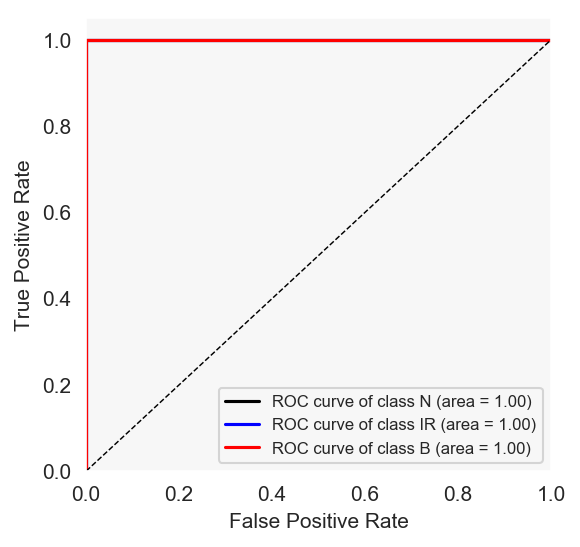

In [27]:
ROC(history.model, images_test, labels_test_factorized, 3)